In [70]:
import math

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [73]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [74]:
datos, metadatos = tfds.load("fashion_mnist", as_supervised=True, with_info=True)

In [75]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='~\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      autho

In [76]:
datos_entrenamiento, datos_prueba = datos["train"], datos["test"]
nombres_clases = metadatos.features["label"].names
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [77]:
# Normalizar los datos (de 0-255 a 0-1)

def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)
    # Lo pasa de 0-255 a 0-1
    imagenes /= 255
    return imagenes, etiquetas

# Normalizar los datos de entrenamiento y pruebas

datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_prueba = datos_prueba.map(normalizar)

# Guardar en cache (se utiliza memoria en lugar de disco para agilizar)

datos_entrenamiento = datos_entrenamiento.cache()
datos_prueba = datos_prueba.cache()

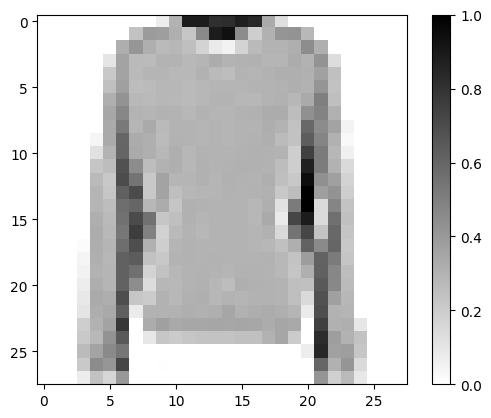

In [78]:
# Mostrar una imagen con los datos de prueba

for imagen, etiqueta in datos_entrenamiento.take(1):
    break
imagen = imagen.numpy().reshape((28, 28))

plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

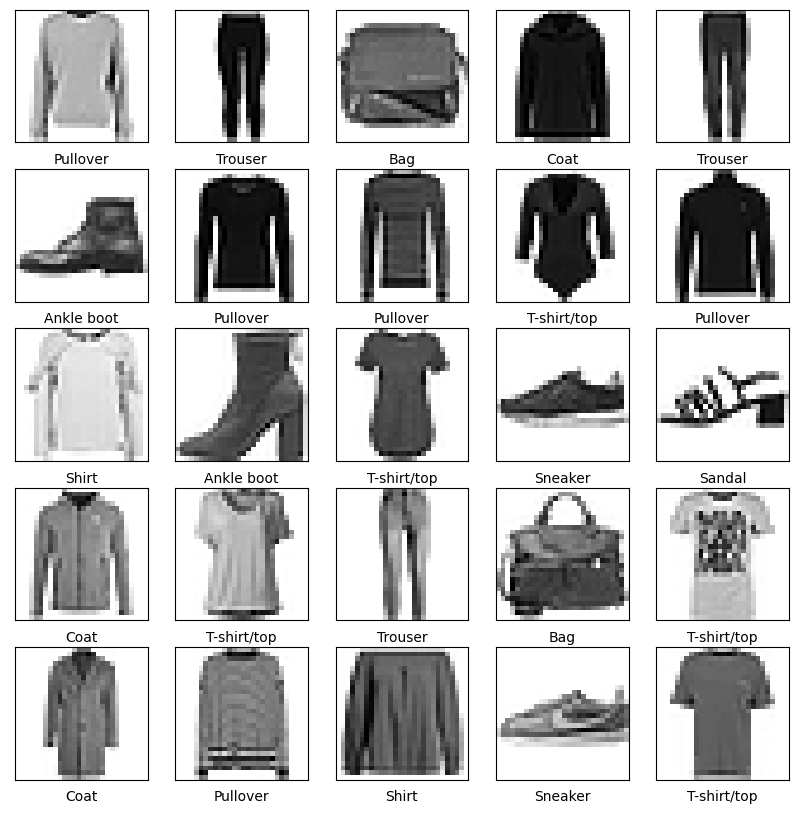

In [79]:
plt.figure(figsize=(10, 10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
    imagen = imagen.numpy().reshape((28, 28))
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagen, cmap=plt.cm.binary)
    plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [81]:
modelo = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
                              tf.keras.layers.Dense(50, activation=tf.nn.relu),
                              tf.keras.layers.Dense(50, activation=tf.nn.relu),
                              tf.keras.layers.Dense(10,
                                                    activation=tf.nn.softmax)
                              ])

In [82]:
modelo.compile(optimizer="adam",
               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics=["accuracy"])

In [83]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [84]:
TAMANO_LOTE = 32

datos_entrenamiento = (datos_entrenamiento
                       .repeat()
                       .shuffle(num_ej_entrenamiento)
                       .batch(TAMANO_LOTE))
datos_prueba = datos_prueba.batch(TAMANO_LOTE)

In [89]:
with tf.device("/GPU:0"):
    historial = modelo.fit(datos_entrenamiento,
                           epochs=15,
                           steps_per_epoch=math.ceil(num_ej_entrenamiento /
                                                     TAMANO_LOTE))

Epoch 1/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2512 - accuracy: 0.9055
Epoch 2/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2440 - accuracy: 0.9086
Epoch 3/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2371 - accuracy: 0.9107
Epoch 4/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2310 - accuracy: 0.9129
Epoch 5/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2315 - accuracy: 0.9131
Epoch 6/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2229 - accuracy: 0.9153
Epoch 7/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2199 - accuracy: 0.9172
Epoch 8/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2078 - accuracy: 0.9210
Epoch 9/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2124 - accuracy: 0.9203
Epoch 10/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.206

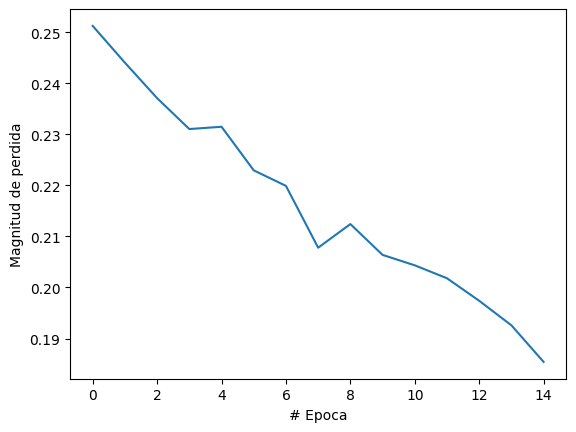

In [90]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])

1/1 [==============================] - 0s 14ms/step


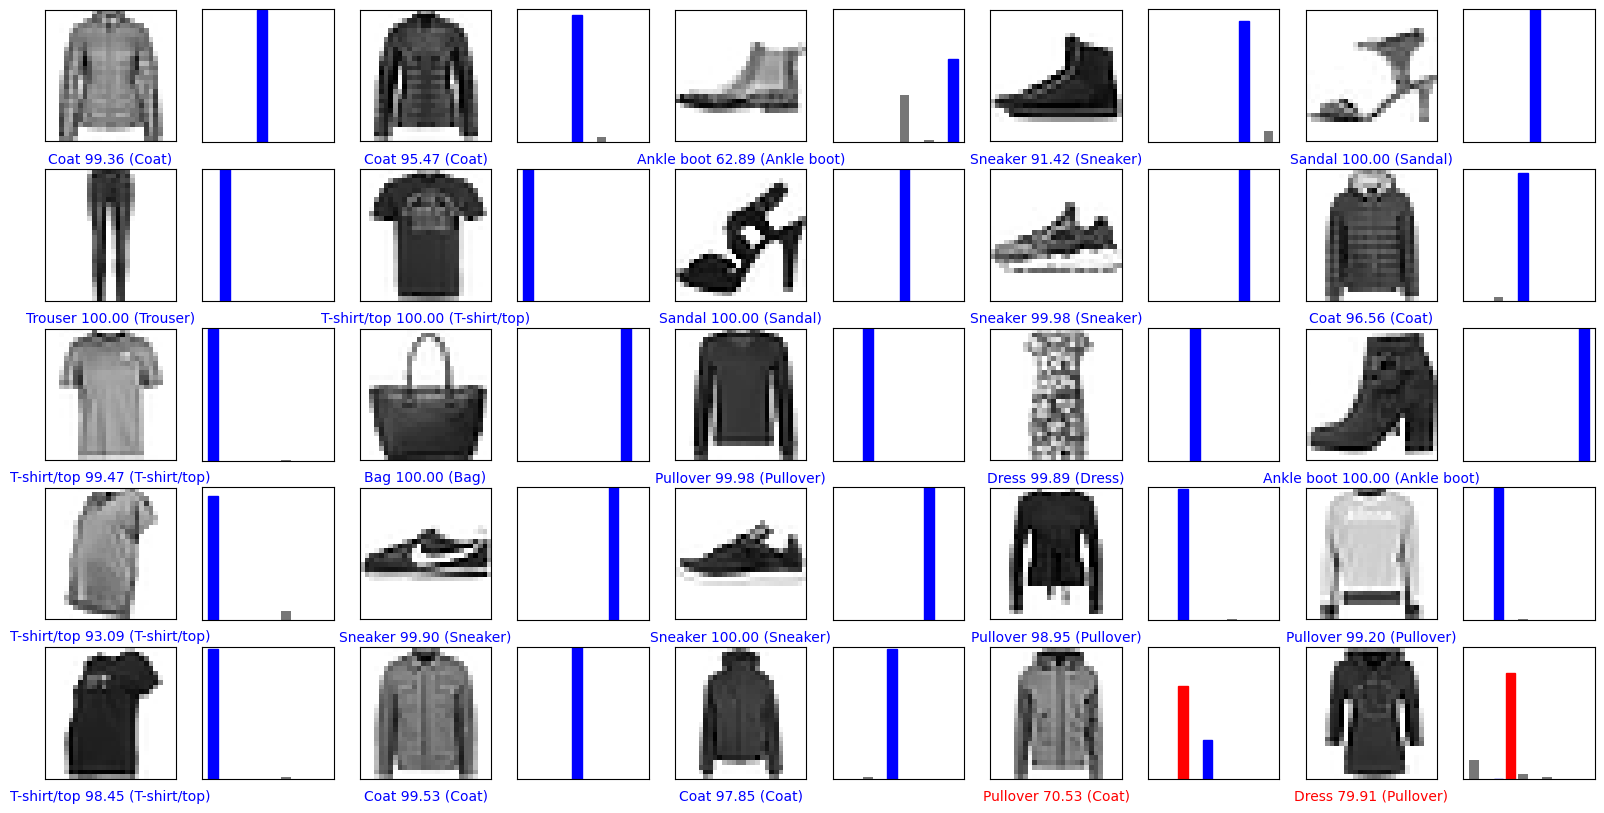

In [91]:
for imagenes_prueba, etiquetas_prueba in datos_prueba.take(1):
    imagenes_prueba = imagenes_prueba.numpy()
    etiquetas_prueba = etiquetas_prueba.numpy()
    predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
    arr_predicciones, etiqueta_real, img = (arr_predicciones[i],
                                            etiquetas_reales[i],
                                            imagenes[i])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[..., 0], cmap=plt.cm.binary)

    etiqueta_prediccion = np.argmax(arr_predicciones)

    # Asigna colores para prediccion o error, azul = si, rojo = no
    if etiqueta_prediccion == etiqueta_real:
        color = "blue"
    else:
        color = "red"

    plt.xlabel(f"{nombres_clases[etiqueta_prediccion]} "
               f"{100 * np.max(arr_predicciones):.2f} "
               f"({nombres_clases[etiqueta_real]})",
               color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiquetas_real):
    arr_predicciones, etiquetas_real = arr_predicciones[i], etiquetas_real[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    grafica = plt.bar(range(10), arr_predicciones, color="#777777")
    plt.ylim([0, 1])
    etiqueta_prediccion = np.argmax(arr_predicciones)

    grafica[etiqueta_prediccion].set_color("red")
    grafica[etiquetas_real].set_color("blue")

filas = 5
columnas = 5
numero_imagenes = filas * columnas
plt.figure(figsize=(2 * 2 * columnas, 2 * filas))
for i in range(numero_imagenes):
    plt.subplot(filas, 2 * columnas, 2 * i + 1)
    graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
    plt.subplot(filas, 2 * columnas, 2 * i + 2)
    graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [92]:
imagen = imagenes_prueba[3]
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)
print(f"Prediccion: {nombres_clases[np.argmax(prediccion[0])]}")

1/1 [==============================] - 0s 15ms/step
Prediccion: Sneaker


In [93]:
modelo.save(r"..\fashion_mnist_modelo.h5")